KMeans聚类步骤：
    1.确定k值，选取k个初始均值向量
    2.计算样本点到k个初始均值向量的距离（欧氏距离、曼哈顿距离、余弦相似度）
    3.划分簇，更新均值向量（簇中心）
    4.重复2.3过程，直至簇中心不在变化

In [1]:
import random 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
df = pd.read_csv('testSet.txt',header =None,names=['x','y'],sep='\t')
#查看数据维度
print(df.shape)
df.head()

(80, 2)


,x,y
0,1.658985,4.285136
1,-3.453687,3.424321
2,4.838138,1.151539
3,-5.379713,-3.362104
4,0.972564,2.924086


In [3]:
df.duplicated().sum() # 查看是否有重复值

0

In [4]:
df.isnull().sum() # 查看是否有缺失值

x    0
y    0
dtype: int64

In [5]:
df.describe()

,x,y
count,80.000000,80.000000
mean,-0.103613,0.083090
std,3.037579,3.052991
min,-5.379713,-4.232586
25%,-2.836842,-3.012599
50%,0.029122,0.955898
75%,2.635250,2.940614
max,4.838138,5.190400


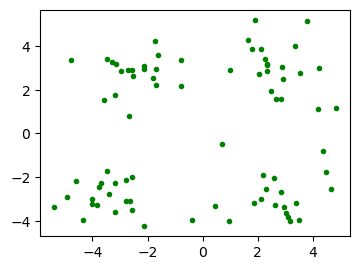

In [6]:
# 绘制散点图
X = df.iloc[:,0]
Y = df.iloc[:,1]
plt.figure(figsize=(4,3),dpi=100)
plt.scatter(X,Y,color='g',marker='.')
plt.show()

In [7]:
df = np.array(df)
df

array([[ 1.658985,  4.285136],
       [-3.453687,  3.424321],
       [ 4.838138,  1.151539],
       [-5.379713, -3.362104],
       [ 0.972564,  2.924086],
       [-3.567919,  1.531611],
       [ 0.450614, -3.302219],
       [-3.487105, -1.724432],
       [ 2.668759,  1.594842],
       [-3.156485,  3.191137],
       [ 3.165506, -3.999838],
       [-2.786837, -3.099354],
       [ 4.208187,  2.984927],
       [-2.123337,  2.943366],
       [ 0.704199, -0.479481],
       [-0.39237 , -3.963704],
       [ 2.831667,  1.574018],
       [-0.790153,  3.343144],
       [ 2.943496, -3.357075],
       [-3.195883, -2.283926],
       [ 2.336445,  2.875106],
       [-1.786345,  2.554248],
       [ 2.190101, -1.90602 ],
       [-3.403367, -2.778288],
       [ 1.778124,  3.880832],
       [-1.688346,  2.230267],
       [ 2.592976, -2.054368],
       [-4.007257, -3.207066],
       [ 2.257734,  3.387564],
       [-2.679011,  0.785119],
       [ 0.939512, -4.023563],
       [-3.674424, -2.261084],
       [

In [8]:
# 使用sklearn库中自带K均值聚类算法
from sklearn.cluster import KMeans
KM = KMeans(n_clusters=4,random_state=0).fit(df)
KM.cluster_centers_

array([[-3.53973889, -2.89384326],
       [ 2.73184457,  3.01548295],
       [-2.46154315,  2.78737555],
       [ 2.54140545, -2.87212285]])

In [9]:
# 随机选择初始聚类中心点
def centerpoint(df,k):
    CenterPoint = []
    CP = df[np.random.choice(df.shape[0],k,replace=False),:] # 从数据集中随机选取k个不同X值及对应Y
    CenterPoint.append(CP) # 生成初始聚类中心点    
    return CenterPoint

In [10]:
# 距离:样本点到聚类中心点的距离算法
def odistance(x,cp):# 欧氏距离
    return math.sqrt((x[0]-cp[0])*(x[0]-cp[0])+(x[1]-cp[1])*(x[1]-cp[1]))    
def mdistance(x,cp):# 曼哈顿距离
    return abs(x[0]-cp[0])+abs(x[1]-cp[1])
def cdistance(x,cp):# 余弦相似度
    return (x[0]*cp[0]+x[1]*cp[1])/(math.sqrt((x[0]*x[0]+x[1]*x[1])*(cp[0]*cp[0]+cp[1]*cp[1])))   

In [11]:
# 计算距离，分簇
def caldis(df,k,distance,CenterPoint):
    # 确定簇类数量，固定簇空间
    labels = []
    for label in range(4):
        labels.append([])
    
    # 计算距离
    dis = []
    for data in df:
        for cp in CenterPoint:
            for i in cp:
                dis.append(distance(data,i))# 样本到簇中心的距离
    
    # 重新构建矩阵，为分簇准备
    dis = np.array(dis)
    dis = dis.reshape(df.shape[0],k) 
    
    # 计算最小距离及下标，分簇
    if distance==odistance or mdistance:
        for i in range(df.shape[0]):
            l = list(dis[i]).index(min(dis[i]))
            labels[l].append(df[i])
    elif distance == cdistance:
        for i in range(df.shape[0]):
            l = list(dis[i]).index(max(dis[i]))
            labels[l].append(df[i])
    else:
        print("未录入此类距离")
    print('聚类中心',CenterPoint)
    print('簇划分',labels)
    
    CP1 = recalcp(k,labels) # 计算均值向量
    print('均值向量',CP1)
    
    if (CenterPoint[0] == CP1[0]).all(): # 若数据一一对应，则表明聚类中心不发生变化，迭代可以结束
        print('迭代结束，返回聚类中心',CenterPoint)
        print('簇划分',labels)
    
    else:
        CenterPoint = CP1 # 若数据存在不同，继续迭代
        CenterPoint,labels=caldis(df,k,distance,CenterPoint)
    
    return CenterPoint,labels

In [12]:
# 分簇后对应的均值向量
def recalcp(k,labels):
    CP1 = []
    for i in range(k):
        sumx = 0
        sumy = 0
        for data in labels[i]:
            sumx += data[0] # X坐标求和
            sumy += data[1] # Y坐标求和
        averx = sumx/len(labels[i]) # X均值
        avery = sumy/len(labels[i]) # Y均值
        CP1.append(list((averx,avery)))
        
    return [np.array(CP1)] # 返回与CenterPoint相同格式，方便迭代

In [13]:
CenterPoint = centerpoint(df,4) 
CPP,labels = caldis(df,4,odistance,CenterPoint)

聚类中心 [array([[-1.616805,  3.573188],
       [ 2.624081, -3.260715],
       [ 3.165506, -3.999838],
       [ 3.367037, -3.184789]])]
簇划分 [[array([1.658985, 4.285136]), array([-3.453687,  3.424321]), array([-5.379713, -3.362104]), array([0.972564, 2.924086]), array([-3.567919,  1.531611]), array([-3.487105, -1.724432]), array([2.668759, 1.594842]), array([-3.156485,  3.191137]), array([4.208187, 2.984927]), array([-2.123337,  2.943366]), array([-0.790153,  3.343144]), array([2.336445, 2.875106]), array([-1.786345,  2.554248]), array([1.778124, 3.880832]), array([-1.688346,  2.230267]), array([2.257734, 3.387564]), array([-2.679011,  0.785119]), array([-3.674424, -2.261084]), array([2.046259, 2.735279]), array([-3.18947 ,  1.780269]), array([1.889034, 5.1904  ]), array([-0.798747,  2.185588]), array([2.096701, 3.886007]), array([-2.709034,  2.923887]), array([2.329546, 3.179764]), array([-3.284816,  3.273099]), array([-3.762093, -2.432191]), array([3.542056, 2.778832]), array([-1.736822, 

In [14]:
# 聚类中心
CPP

[array([[-2.46154315,  2.78737555],
        [-3.38237045, -2.9473363 ],
        [ 2.69581468, -2.81467121],
        [ 2.73184457,  3.01548295]])]

In [15]:
# 分簇结果
labels

[[array([-3.453687,  3.424321]),
  array([-3.567919,  1.531611]),
  array([-3.156485,  3.191137]),
  array([-2.123337,  2.943366]),
  array([-0.790153,  3.343144]),
  array([-1.786345,  2.554248]),
  array([-1.688346,  2.230267]),
  array([-2.679011,  0.785119]),
  array([-3.18947 ,  1.780269]),
  array([-0.798747,  2.185588]),
  array([-2.709034,  2.923887]),
  array([-3.284816,  3.273099]),
  array([-1.736822,  4.241041]),
  array([-4.786473,  3.358547]),
  array([-2.513661,  2.642162]),
  array([-2.562539,  2.884438]),
  array([-1.616805,  3.573188]),
  array([-1.685703,  2.939697]),
  array([-2.133863,  3.093686]),
  array([-2.967647,  2.848696])],
 [array([-5.379713, -3.362104]),
  array([-3.487105, -1.724432]),
  array([-2.786837, -3.099354]),
  array([-0.39237 , -3.963704]),
  array([-3.195883, -2.283926]),
  array([-3.403367, -2.778288]),
  array([-4.007257, -3.207066]),
  array([-3.674424, -2.261084]),
  array([-2.579316, -3.497576]),
  array([-3.837877, -3.253815]),
  array([

In [16]:
# 获得数据的x,y,并贴标签
ll=[]
for i in range(len(labels)):
    df1 = pd.DataFrame(labels[i])
    df1['label'] = i
    ll.append(df1)

X,Y,L = [],[],[]
for i in range(len(ll)):
    x = list(ll[i].iloc[:,0])
    X.append(x)
    y = list(ll[i].iloc[:,1])
    Y.append(y)
    l = list(ll[i].iloc[:,2])
    L.append(l)

In [21]:
ll

[           0         1  label
 0  -3.453687  3.424321      0
 1  -3.567919  1.531611      0
 2  -3.156485  3.191137      0
 3  -2.123337  2.943366      0
 4  -0.790153  3.343144      0
 5  -1.786345  2.554248      0
 6  -1.688346  2.230267      0
 7  -2.679011  0.785119      0
 8  -3.189470  1.780269      0
 9  -0.798747  2.185588      0
 10 -2.709034  2.923887      0
 11 -3.284816  3.273099      0
 12 -1.736822  4.241041      0
 13 -4.786473  3.358547      0
 14 -2.513661  2.642162      0
 15 -2.562539  2.884438      0
 16 -1.616805  3.573188      0
 17 -1.685703  2.939697      0
 18 -2.133863  3.093686      0
 19 -2.967647  2.848696      0,
            0         1  label
 0  -5.379713 -3.362104      1
 1  -3.487105 -1.724432      1
 2  -2.786837 -3.099354      1
 3  -0.392370 -3.963704      1
 4  -3.195883 -2.283926      1
 5  -3.403367 -2.778288      1
 6  -4.007257 -3.207066      1
 7  -3.674424 -2.261084      1
 8  -2.579316 -3.497576      1
 9  -3.837877 -3.253815      1
 10 -2.

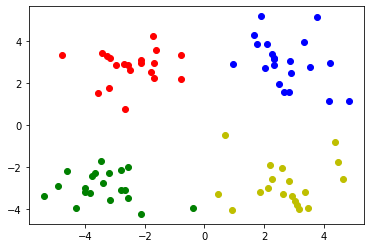

In [18]:
# 绘制散点图
colors =['r','g','y','b']
for i in range(len(L)):
    #X[i],Y[i],L[i]
    plt.scatter(X[i],Y[i],c=colors[i])
plt.show()
    